# **Test integration of DP Langevin**

Simple Jupyter notebook testing an adaptation of the Villa Martín/Buendía (VMB)
implementation of the Dornic et al (2005) method of integrating DP/APT-type
Langevin equations using an operator-splitting method. Access to the heavily 
refactored VMB C++ code is provided via a pybind11 wrapper.

See the main README for references.

<hr>

## Preliminaries

In [1]:
from typing import Any, Sequence, Callable
import numpy as np
from numpy.typing import NDArray
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.colors import ListedColormap, Colormap
# import sys, os
# sys.path.insert(0, os.path.join(os.path.pardir, "build"))
import dplvn
import initialize

font_size = 11
font_family = "Arial"
try:
    mpl.rc("font", size=font_size, family=font_family)
except:
    mpl.rc("font", size=font_size, family="")

In [2]:
density_dict: dict[float, NDArray] = {}
fig_dict: dict[str, Any] = {}
density_image_dict: dict[int, Any] = {}
bold = lambda str: ("\033[1m" + str + "\033[0m")

<hr>

## `dplvn` info

In [3]:
print(f"dplvn version:  {dplvn.__version__}")

dplvn version:  2025.10.10a3


In [4]:
# help(dplvn)

In [5]:
# help(dplvn.SimDP)

<hr>

## Demo

Perform demo integration of a DP Langevin on a small grid with simple choices of parameters.

In [6]:
# # 1d example with DP behavior turned off, and only diffusion manifest
# sim = dplvn.SimDP(
#     linear=1.0e-5, quadratic=2.0e-5, diffusion=0.1, noise=0.001, 
#     t_final=20.0-1e-10, 
#     dx=0.5, dt=0.01,
#     random_seed=2,
#     grid_dimension=dplvn.D1,
#     grid_size=(20,),
#     ic_values=(3, 10,),
#     grid_topologies=(dplvn.PERIODIC,),
#     boundary_condition=dplvn.FLOATING,
#     initial_condition=dplvn.SINGLE_SEED,
#     integration_method=dplvn.RUNGE_KUTTA
# )
# do_extend = False
# do_bar = False

In [7]:
# # 2d example with DP behavior turned off, and only diffusion manifest
# # By choosing different "grid_topologies", demonstrates mixed edge topology.

# sim = dplvn.SimDP(
#     linear=1.0e-5, quadratic=2.0e-5, diffusion=0.1, noise=0.001, 
#     t_final=20.0-1e-10, 
#     dx=0.5, dt=0.01,
#     random_seed=2,
#     grid_dimension=dplvn.D2,
#     grid_size=(30,20,),

#     # gts here mean (x-axis edges, y-axis edges)
#     #   - they don't mean x, y *directions*
#     #   - rather they mean respectively y, x directions

#     # grid_topologies=(dplvn.BOUNDED,dplvn.BOUNDED,),
#     # ic_values=(3.0, 25, 3,),

#     # grid_topologies=(dplvn.PERIODIC,dplvn.BOUNDED,),
#     # ic_values=(3.0, 5, 3,),
#     # # ic_values=(3.0, 25, 3,),
#     # # ic_values=(3.0, 15, 9,),

#     grid_topologies=(dplvn.BOUNDED,dplvn.PERIODIC,),
#     ic_values=(3.0, 25, 3,),
#     # ic_values here mean (single seed value, s.s. x, s.s. y)

#     # grid_topologies=(dplvn.PERIODIC,dplvn.PERIODIC,),
#     # ic_values=(3.0, 25, 3,),

#     boundary_condition=dplvn.FLOATING,
#     # initial_condition=dplvn.RANDOM_UNIFORM,
#     initial_condition=dplvn.SINGLE_SEED,
#     integration_method=dplvn.RUNGE_KUTTA
# )
# do_extend = True
# do_bar = True

In [8]:
# Medium-small demo for README
sim = dplvn.SimDP(
    linear=1.0, quadratic=2.0, diffusion=0.1, noise=1.0, t_final=20.0-1e-10, 
    dx=0.5, dt=0.01,
    random_seed=2,
    grid_dimension=dplvn.D2,
    # grid_size=(40,25,),
    grid_size=(100,60,),
    grid_topologies=(dplvn.BOUNDED, dplvn.PERIODIC,),
    # boundary_condition=dplvn.FLOATING,
    boundary_conditions=(
        # dplvn.FLOATING, dplvn.FLOATING, dplvn.FLOATING, dplvn.FLOATING,
        dplvn.FIXED_VALUE, dplvn.FIXED_VALUE, dplvn.FLOATING, dplvn.FLOATING,
    ),
    bc_values=(-2,+2,0,0),
    initial_condition=dplvn.RANDOM_UNIFORM,
    integration_method=dplvn.RUNGE_KUTTA
)
do_extend = False
do_bar = True

linear: 1
quadratic: 2
diffusion: 0.1
noise: 1
t_final: 20
dx: 0.5
dt: 0.01

random_seed: 2
grid_dimension: 2d
grid_size: 100 60 
n_cells: 6000
grid_topologies: x:bounded; y:periodic
boundary_conditions: x0:fixed value, x1:fixed value; y0:floating, y1:floating
bc_values: -2 2 0 0 
initial_condition: random uniform values
ic_values: 0 0 0 
integration_method: Runge-Kutta


In [9]:
if not sim.initialize():
    raise Exception("Failed to initialize sim")
n_epochs: int = sim.get_n_epochs()
print()
print(f"Number of sim epochs = {n_epochs}")


Number of sim epochs = 2001


In [10]:
n_segments: int = 5
n_segment_epochs: int = (n_epochs-1) // n_segments
if (n_segment_epochs*n_segments+1)!=n_epochs:
    raise Exception(
        f"Failed to segment sim with {n_epochs} epochs "
        + "into {n_segments} segment(s)"
    )

In [11]:
for i_segment in range(0, n_segments+1, 1):
    if i_segment>0 and not sim.run(n_segment_epochs):
        raise Exception("Failed to run sim")
    if not sim.postprocess():
        raise Exception("Failed to process sim results")
    i_epoch = sim.get_i_current_epoch()
    t_epoch = np.round(sim.get_t_current_epoch())
    density_dict[t_epoch] = sim.get_density()
    print(bold(
        f"segment={i_segment}/{n_segments}  "
        + f"i={i_epoch} t={t_epoch}"
    ))
    # print(f"t epochs:  {sim.get_t_epochs()}")
    # print(f"mean densities:  {sim.get_mean_densities()}")
    # print("cell density grid:")
    # print(np.round(density_dict[t_epoch].T, 2), flush=True)
    # print(flush=True)

segment=0/5  i=0 t=0.0
segment=1/5  i=400 t=4.0
segment=2/5  i=800 t=8.0
segment=3/5  i=1200 t=12.0
segment=4/5  i=1600 t=16.0
segment=5/5  i=2000 t=20.0


Simulation results are returned as a `numpy` array with integration time steps
("epochs") in the first column and grid-mean density ("mean_densities") in the
second column. 

In [12]:
t_epochs: NDArray = sim.get_t_epochs()
mean_densities: NDArray = sim.get_mean_densities()
t_epochs[-10:], mean_densities[-10:]

(array([19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99,
        20.  ]),
 array([0.23901367, 0.23890604, 0.23951075, 0.24062152, 0.24042377,
        0.24020753, 0.24101788, 0.24097806, 0.24017896, 0.23943713]))

<hr>

## Plot

In [13]:
def plot_density_image(
        t_epoch: float, 
        density: NDArray,
        do_extend: bool=True,
    ):
    fig = plt.figure(figsize=(6,6,))
    color_palette: str = "inferno_r"
    color_map: Colormap = plt.get_cmap(color_palette) #type: ignore
    grid_: NDArray = np.flipud(density.T)
    n_pad_ud: int = max(grid_.shape[0]//4, 8)
    n_pad_lr: int = max(grid_.shape[1]//4, 8)
    if do_extend:
        grid_ = np.vstack([grid_[n_pad_ud:], grid_])
        grid_ = np.hstack([grid_, grid_[:,:n_pad_lr]])
    (n_ud, n_lr,) = grid_.shape
    plt.imshow(
        grid_,  
        extent=(0, n_lr, 0, n_ud), 
        cmap=color_map,
        vmin=0, #vmax=2,
        # vmin=0.2, vmax=0.9,
    )
    if do_bar:
        ticks: NDArray = np.arange(0, 3, 0.5,)
        color_bar: Any = plt.colorbar(
            shrink=0.35, pad=0.05, aspect=12, ticks=ticks, extend="max",
        )
        color_bar.set_label(r"$\rho(\mathbf{x},t)$  [-]")
    plt.title(r"density  $\rho(\mathbf{x},t=$" 
              + f"{t_epoch:0{4}.1f}" + r"$)$")
    plt.xlabel(r"$x$   [-]")
    plt.ylabel(r"$y$   [-]")
    plt.grid(ls=":")
    plt.close()
    return fig

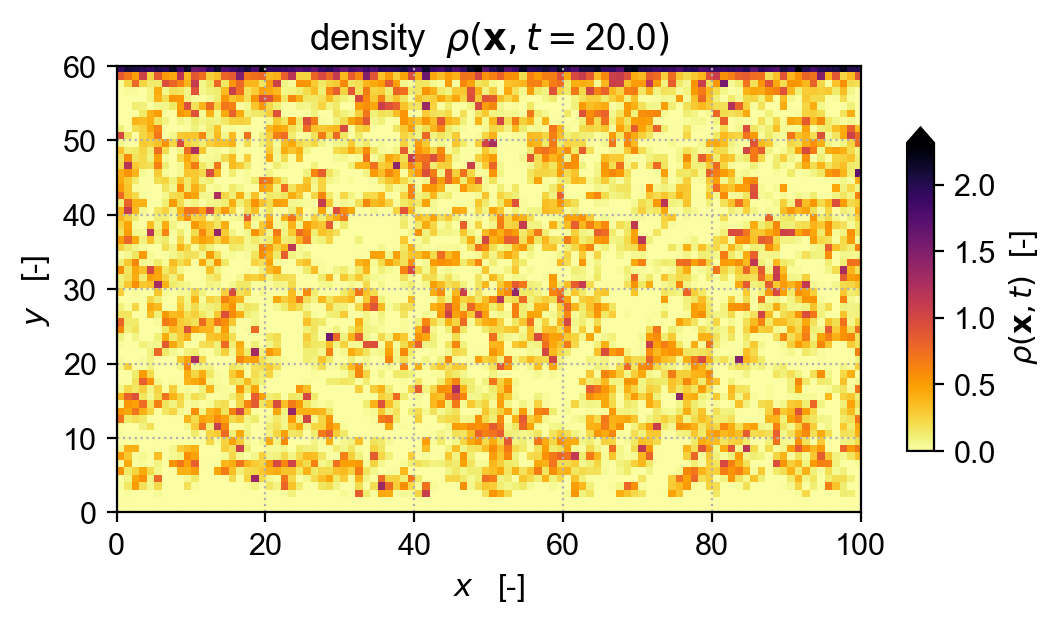

In [14]:
for i_epoch_, t_epoch_ in enumerate(density_dict.keys()):
    density_ = density_dict[t_epoch_]
    density_image_dict[i_epoch_] \
        = plot_density_image(t_epoch_, density_, do_extend=do_extend,)
density_image_dict[n_segments]

Plot the time-series of the grid-averaged density field.

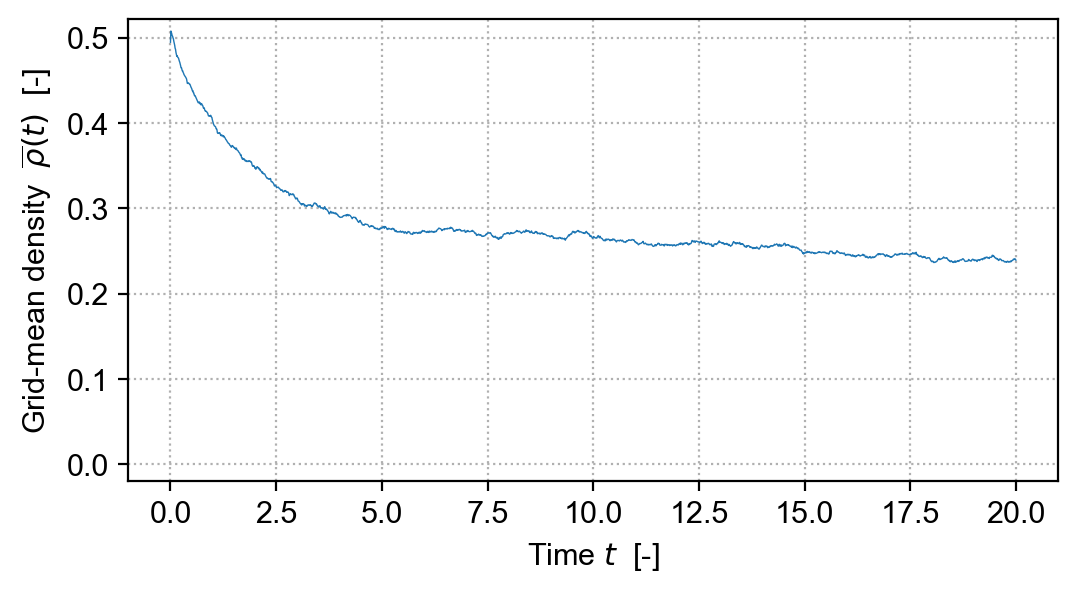

In [15]:
fig_dict.update({"meandensity_time": plt.figure(figsize=(6, 3,))})
plt.plot(t_epochs, mean_densities, "-", lw=0.5,)
plt.xlabel(r"Time $t$  [-]")
plt.ylabel(r"Grid-mean density  $\overline{\rho}(t)$  [-]")
plt.ylim(-0.02, None)
plt.grid(ls=":")

<hr>

## Save

In [16]:
for fig_ in fig_dict.keys():
    fig_name_ = f"{fig_}.png"
    print(fig_name_)
    fig_dict[fig_].savefig(
        fig_name_,
        bbox_inches="tight",
        pad_inches=0.05,
        dpi=150,
        format="PNG",
    )

meandensity_time.png


In [17]:
fig_name_ = "density_grid.png"
print(fig_name_)
density_image_dict[n_segments].savefig(
    fig_name_,
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=150,
    format="PNG",
)

density_grid.png
